# Configure Environment

## Mount google drive

In [42]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import packages

In [0]:
!apt install python3-cartopy
!pip install rasterio
!pip install shapely
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python3-pkg-resources python3-pyshp python3-shapely python3-six
Suggested packages:
  python3-matplotlib python3-owslib python3-pil python3-pyepsg python3-scipy
  python3-setuptools python-shapely-doc
The following NEW packages will be installed:
  python3-cartopy python3-pkg-resources python3-pyshp python3-shapely
  python3-six
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 5,570 kB of archives.
After this operation, 10.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-pyshp all 1.2.12+ds-1 [31.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-shapely amd64 1.6.4-1 [213 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/ma

In [0]:
# IO packages
import os
import json
# Data processing
import numpy as np
from operator import itemgetter
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
# Visualization
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import geopandas as gpd
import pprint

## Define Functions

In [0]:
def diff_stats(diff_hist):
    stats = {}
    stats["total_pixels"] = diff_hist[0] + diff_hist[1] + diff_hist[2] + diff_hist[3]
    stats["correct"] = diff_hist[0] + diff_hist[3]
    stats["incorrect"] = diff_hist[1] + diff_hist[2]
    
    stats["notrock"] = diff_hist[0]
    stats["false_notrock"] = diff_hist[1]
    stats["false_rock"] = diff_hist[2]
    stats["rock"] = diff_hist[3]
                    
    stats["accuracy"] = stats["correct"] / stats["total_pixels"]
    stats["classification_accuracy"] = stats["rock"] / (stats["rock"] + stats["false_rock"] + stats["false_notrock"])
    stats["rock_omission"] = diff_hist[1] / (diff_hist[1] + diff_hist[3])
    stats["rock_commission"] = diff_hist[2] / (diff_hist[2] + diff_hist[3])
    stats["notrock_omission"] = diff_hist[2] / (diff_hist[0] + diff_hist[2])
    stats["notrock_commission"] = diff_hist[1] / (diff_hist[0] + diff_hist[1])
    stats["f1_rock"] = 2 * ((stats["rock_omission"] * stats["rock_commission"]) / (stats["rock_omission"] + stats["rock_commission"]))

    stats["rock_producers"] = diff_hist[3] / (diff_hist[1] + diff_hist[3]) * 100
    stats["notrock_producers"] = diff_hist[0] / (diff_hist[0] + diff_hist[2]) * 100
    stats["rock_users"] = diff_hist[3] / (diff_hist[2] + diff_hist[3]) * 100
    stats["notrock_users"] = diff_hist[0] / (diff_hist[0] + diff_hist[1]) * 100

    return stats

In [0]:
def assemble_scene_output(scene_output_dir, window, suffix):
    chunks = []
    row_vals = [i[0] for i in window['chunks']]
    col_vals = [i[1] for i in window['chunks']]
    row_range = (min(row_vals), max(row_vals))
    col_range = (min(col_vals), max(col_vals))
   
    mosaic_rows = []
    for i in range(row_range[0], row_range[1] + 1):
        row = []
        for j in range(col_range[0], col_range[1] + 1):
            row.append(np.load(os.path.join(scene_output_dir, "chunk_{}_{}{}.npy".format(i, j, suffix))))
        
        mosaic_rows.append(np.concatenate(tuple(row), axis=1))
    
    mosaic = np.concatenate(tuple(mosaic_rows), axis=0)
    
    return mosaic[window["row"]: window["row"] + window["height"],
                            window["col"]: window["col"] + window["width"]]


## Define data paths

In [0]:
base_dir = "/content/drive/My Drive"
model_dir = os.path.join(base_dir, "models/")
model_name = "model_allBands_best_lr_0.01"
model_path = os.path.join(model_dir, model_name)
output_path = os.path.join(base_dir, "output", model_name)
label_path = os.path.join(base_dir, "test_chunks")

In [0]:
qc_dir = os.path.join(base_dir, "qc")
qc_chunk_dir = os.path.join(qc_dir, "manual_labels")
window_path = os.path.join(qc_dir, "chunk_windows.json")

# Load window metadata

In [0]:
with open(window_path, 'r') as window_file:
    windows = json.load(window_file)

# Load output and manual chunks

In [0]:
output_chunks = {}
label_chunks = {}
man_chunks = {}

for i in windows:
    if i == "ryder_bay_abj":
        scene_dir = os.path.join(output_path, "LC82201072015017LGN00")
        label_dir = os.path.join(base_dir, "test_chunks", "LC82201072015017LGN00")
    else:
        scene_dir = os.path.join(output_path, i)
        label_dir = os.path.join(base_dir, "test_chunks", i)
    if os.path.exists(scene_dir):
        output_chunks[i] = assemble_scene_output(scene_dir, windows[i], "_output")
        man_path = os.path.join(qc_chunk_dir, i + "_man.npy")
        man_chunks[i] = np.load(man_path)
        label_chunks[i] = assemble_scene_output(label_dir, windows[i], "_label")

# Analyze outputs

## Generate diff rasters

In [0]:
diffs = {}
for i in output_chunks:
    actual = output_chunks[i] * 2 
    diffs[i] = man_chunks[i] + actual


In [0]:
label_diffs = {}
for i in label_chunks:
    actual = label_chunks[i] * 2 
    label_diffs[i] = man_chunks[i] + actual

## Generate diff histograms

In [0]:
diff_hists = {}
for i in diffs:
    diff_hists[i] = np.histogram(diffs[i], bins=[0,1,2,3,4])[0]

In [0]:
label_hists = {}
for i in label_diffs:
    label_hists[i] = np.histogram(label_diffs[i], bins=[0,1,2,3,4])[0]

## Create summary statistics

In [0]:
diff_statistics = {}
for i in diff_hists:
    diff_statistics[i] = diff_stats(diff_hists[i])

In [0]:
label_statistics = {}
for i in label_hists:
    label_statistics[i] = diff_stats(label_hists[i])


## Visualization

### Visualize model results

#### Convert output to shapefile

In [0]:
def diff_to_shapes(diff):
    with rasterio.Env():
        image = diff.astype('int16')
        tn = []
        fn = []
        fp = []
        tp = []
        for geometry, raster_value in shapes(image):
            result = {'properties': {'raster_value': raster_value}, 'geometry': geometry}
            if raster_value == 0:
                tn.append(result)
            if raster_value == 1:
                fn.append(result)
            if raster_value == 2:
                fp.append(result)
            if raster_value == 3:
                tp.append(result)
        
    result = {}
    result["true_negatives"] = gpd.GeoDataFrame.from_features(tn)
    result["false_negatives"] = gpd.GeoDataFrame.from_features(fn)
    result["false_positives"] = gpd.GeoDataFrame.from_features(fp)
    result["true_positives"] = gpd.GeoDataFrame.from_features(tp)
    return result


#### Load data chunk and normalize it for visualization as image with matplotlib.pylot.imshow

In [0]:
norms = {}
for i in windows:
    if i == "ryder_bay_abj":    
        stack_mosaic = assemble_scene_output(os.path.join(label_path, "LC82201072015017LGN00"), windows[i], "")
    else:
        stack_mosaic = assemble_scene_output(os.path.join(label_path, i), windows[i], "")
    norm = np.zeros(stack_mosaic.shape)
    for j in range(stack_mosaic.shape[2]):
        norm[:,:,j] = stack_mosaic[:,:,j] / np.amax(stack_mosaic[:,:,j])
    norms[i] = norm

#### Plot polygons on top of normalized RGB image and save to drive

In [0]:
from matplotlib.lines import Line2D
results_figure_dir = os.path.join(base_dir, "figures", "results", model_name)
if not os.path.exists(results_figure_dir):
    os.mkdir(results_figure_dir)

for i in diffs:
    polys = diff_to_shapes(diffs[i])
    fig, ax = plt.subplots(figsize=(12,12))
    
    ax.set_title(i, fontsize=40)
    legend_lines = []
    legend_labels = []
    # ("true_negatives", 'red'), 
    for j in [("false_negatives", '#f4f73b'), ("false_positives", '#c7180c'),
            ("true_positives", '#2abe2f')]:
        legend_lines.append(Line2D([0], [0], color=j[1], lw=4))
        legend_labels.append(j[0])
        polys[j[0]].plot(facecolor='none', edgecolor=j[1], linewidth=1.5, ax=ax)


    ax.imshow(norms[i][:,:,1:4])
    ax.legend(legend_lines, legend_labels)

    fig.savefig(os.path.join(results_figure_dir, "{}.png".format(i)), bbox_inches='tight', transparent=True)


Output hidden; open in https://colab.research.google.com to view.

### Visualize data bands

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [0]:
sample_stack = norms["LC80631112014002LGN00"]
band_figure_dir = os.path.join(base_dir, "figures", "bands")
if not os.path.exists(band_figure_dir):
    os.mkdir(band_figure_dir)

band_colors = [("Deep blues and violets", 'Purples_r'), ("Blue", 'Blues_r'), ("Green", "Greens_r"), ("Red", "Reds_r"), 
               ("Near Infrared", "Oranges_r"), ("Shortwave Infrared1", "pink"), ("Shortwave Infrared2", "pink"), ("Clouds", "binary"), ("Thermal Infrared", "coolwarm"),
               ("Thermal Infrared", "coolwarm")]
band_number = [1,2,3,4,5,6,7,9,10,11]
for i in range(10):
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(sample_stack[:,:,i], cmap=band_colors[i][1])
    ax.set_title("Band {}: {}".format(band_number[i], band_colors[i][0]), fontsize=40)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    fig.savefig(os.path.join(band_figure_dir, "Band_{}.png".format(band_number[i])), bbox='tight', transparent=True)

Output hidden; open in https://colab.research.google.com to view.

### Visualize Burton-Johnson et. al. Band combinations

In [0]:
tirs_v_blue = sample_stack[:,:,8] / sample_stack[:,:,1]

In [0]:
ndsi = (sample_stack[:,:,2] - sample_stack[:,:,5]) / (sample_stack[:,:,2] + sample_stack[:,:,5])

In [0]:
ndwi = (sample_stack[:,:,2] - sample_stack[:,:,4]) / (sample_stack[:,:,2] + sample_stack[:,:,4])

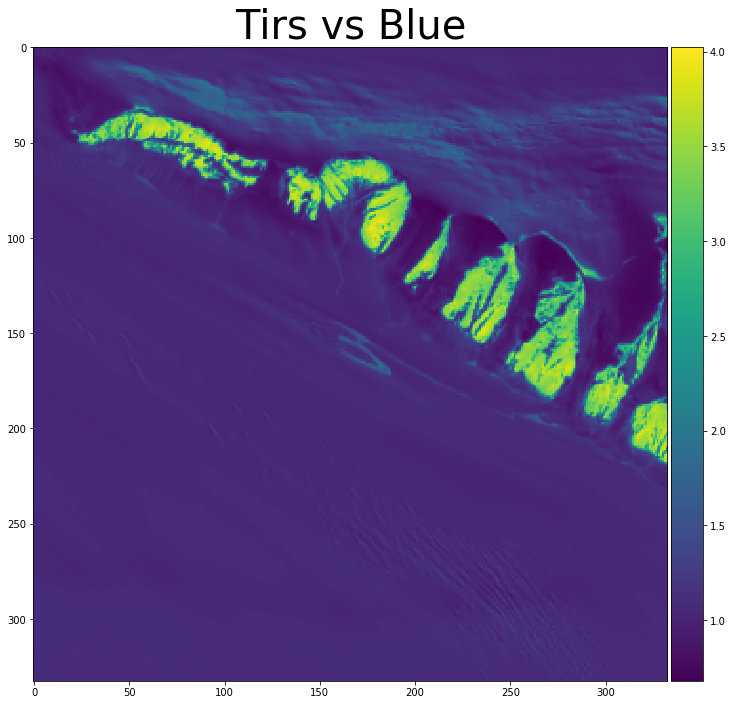

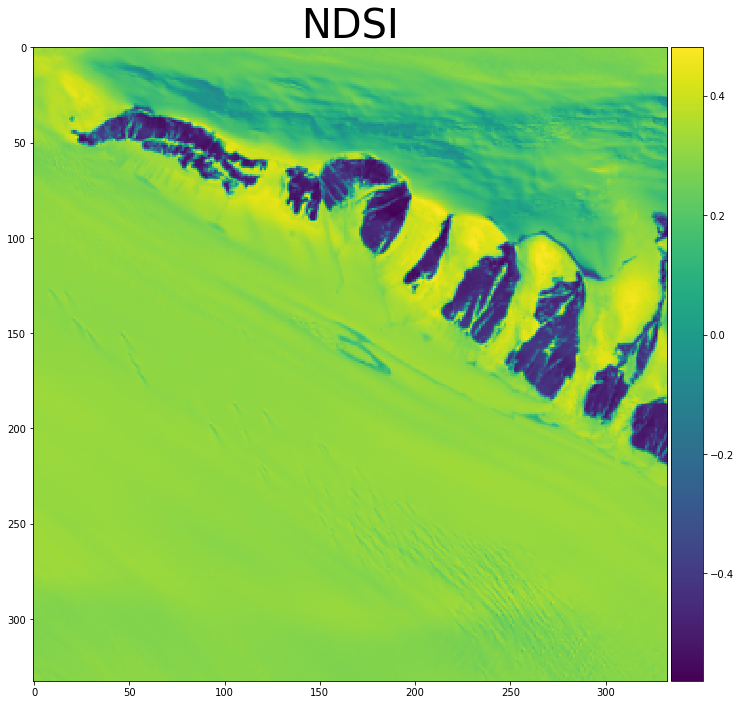

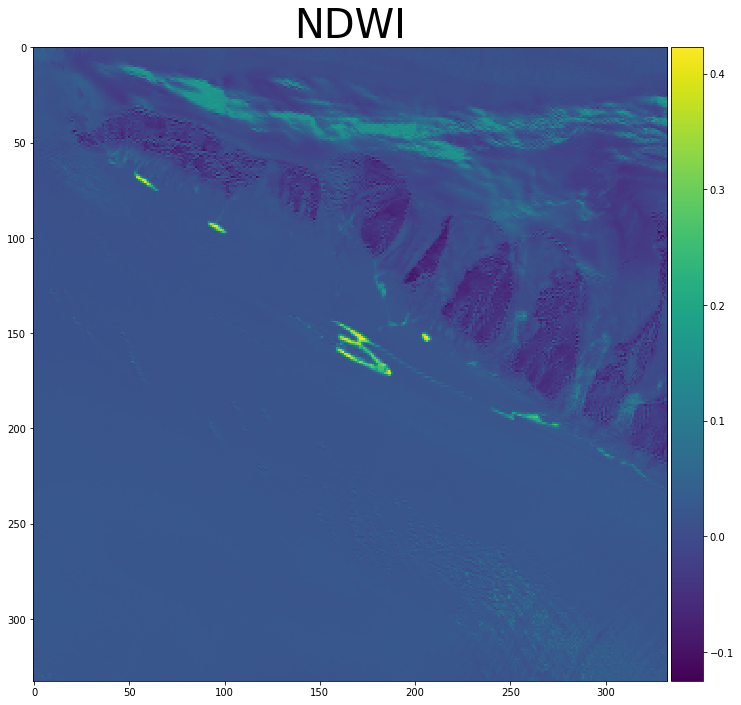

In [0]:
heuristic_dir = os.path.join(base_dir, "figures", "abj_heuristics")
if not os.path.exists(heuristic_dir):
    os.mkdir(heuristic_dir)

for i in [("Tirs vs Blue", tirs_v_blue), ("NDSI", ndsi), ("NDWI", ndwi)]:
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(i[1])
    ax.set_title(i[0], fontsize=40)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    fig.savefig(os.path.join(heuristic_dir, "{}.png".format(i[0])), bbox='tight', transparent=True)

## Visualize metric trends

### Load image metadata

In [0]:
def scrape_metadata(path):
    fields = ["CLOUD_COVER", "IMAGE_QUALITY_OLI", "IMAGE_QUALITY_TIRS",
              "SUN_AZIMUTH", "SUN_ELEVATION", "EARTH_SUN_DISTANCE",
              "CORNER_UL_LAT_PRODUCT"]
    metadata = {}
    separator = " = "
    sep_len = len(separator)
    
    with open(path, 'r') as file:
        for i in file.readlines():
            try:
                separator_pos = i.index(separator)
                key = i[:separator_pos].strip()
                value = i[separator_pos + sep_len:].strip()
                for j in fields:
                    if key[:len(j)] == j:
                        metadata[j] = value
            except ValueError as e:
                pass
    return metadata

In [0]:
metadata = {}
for i in windows:
    if i == "ryder_bay_abj":
        metadata_path = os.path.join(base_dir, "qc", "image_metadata", "LC82201072015017LGN00_MTL.txt")
    else:
        metadata_path = os.path.join(base_dir, "qc", "image_metadata", "{}_MTL.txt".format(i))
    metadata[i] = scrape_metadata(metadata_path)

In [52]:
print(metadata)
print(diff_statistics)

{'LC80311222014338LGN00': {'CORNER_UL_LAT_PRODUCT': '-83.42702', 'CLOUD_COVER': '1.81', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '117.12274005', 'SUN_ELEVATION': '18.72338007', 'EARTH_SUN_DISTANCE': '0.9855587'}, 'LC80631112014002LGN00': {'CORNER_UL_LAT_PRODUCT': '-73.48063', 'CLOUD_COVER': '3.22', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '62.11020434', 'SUN_ELEVATION': '32.39885959', 'EARTH_SUN_DISTANCE': '0.9833397'}, 'LC81041072013303LGN00': {'CORNER_UL_LAT_PRODUCT': '-68.54996', 'CLOUD_COVER': '2.83', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '48.79628860', 'SUN_ELEVATION': '30.20659331', 'EARTH_SUN_DISTANCE': '0.9930934'}, 'LC81431082013352LGN00': {'CORNER_UL_LAT_PRODUCT': '-68.36069', 'CLOUD_COVER': '0.34', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '56.85080080', 'SUN_ELEVATION': '37.06220044', 'EARTH_SUN_DISTANCE': '0.9839594'}, 'LC81681112014002LGN00': {'CORNER_UL_LAT_PRODU

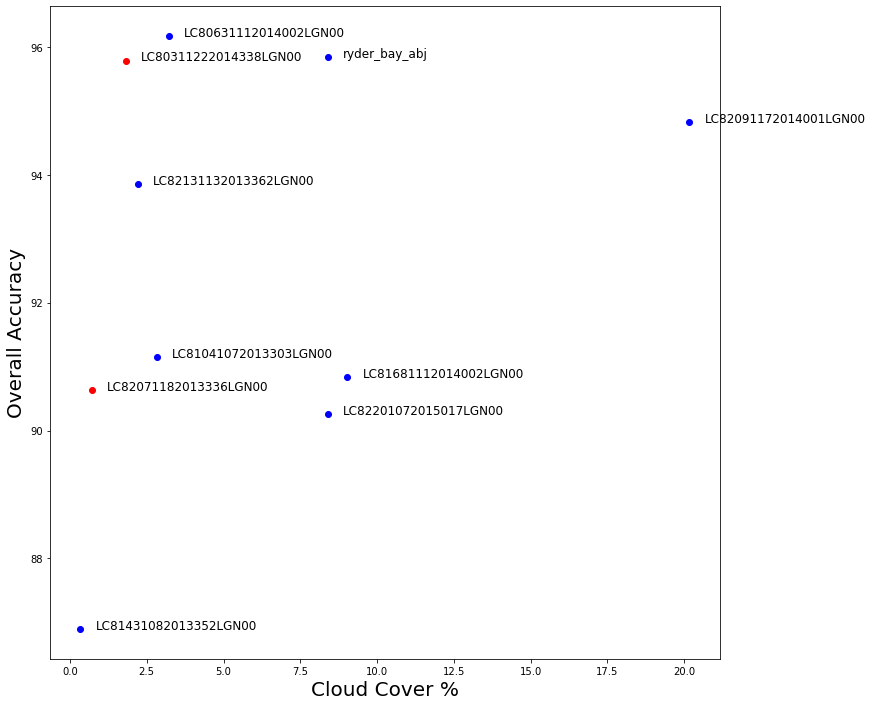

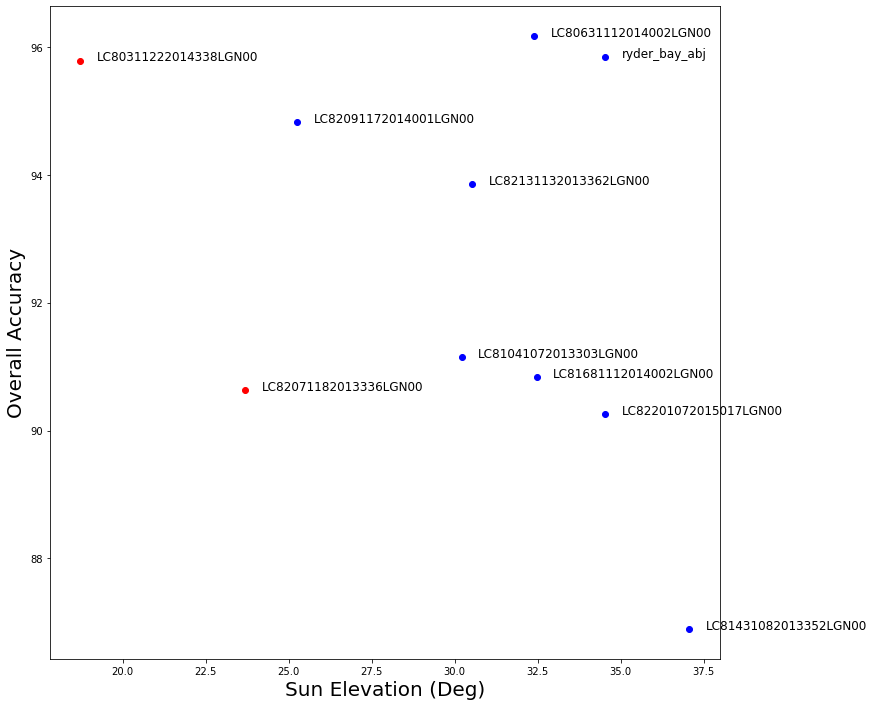

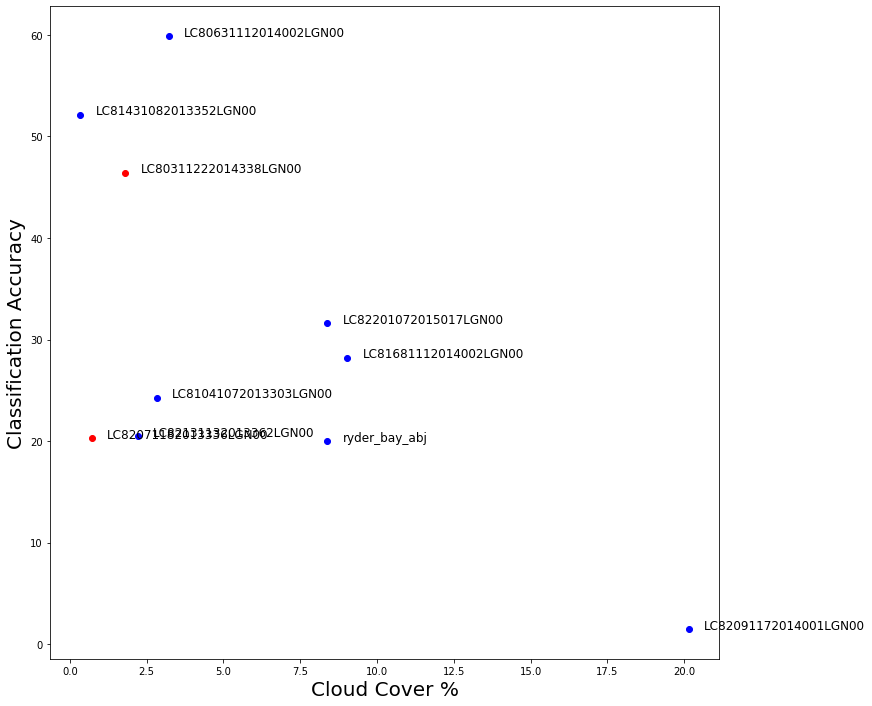

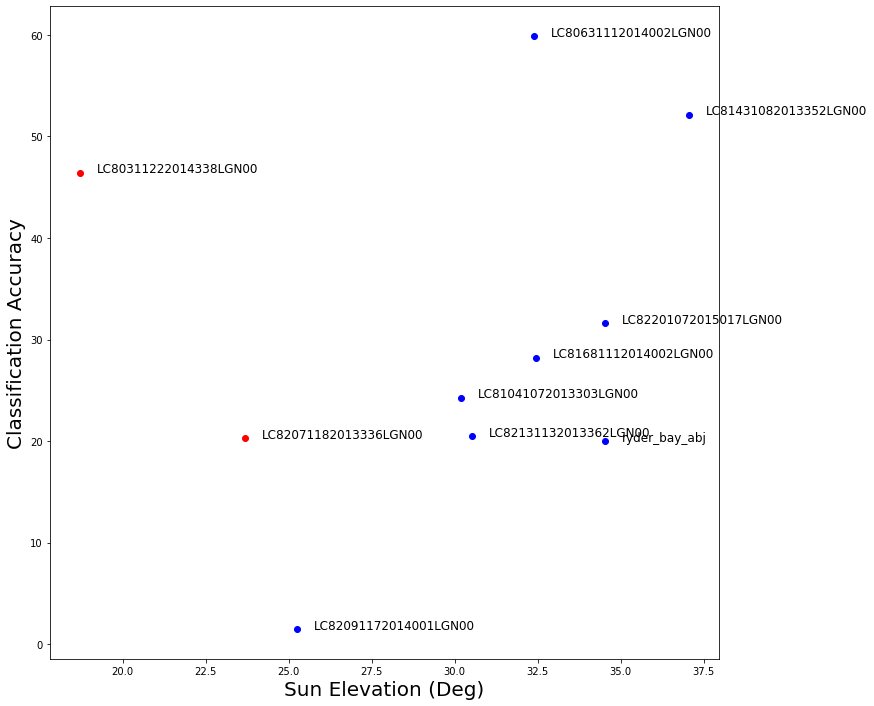

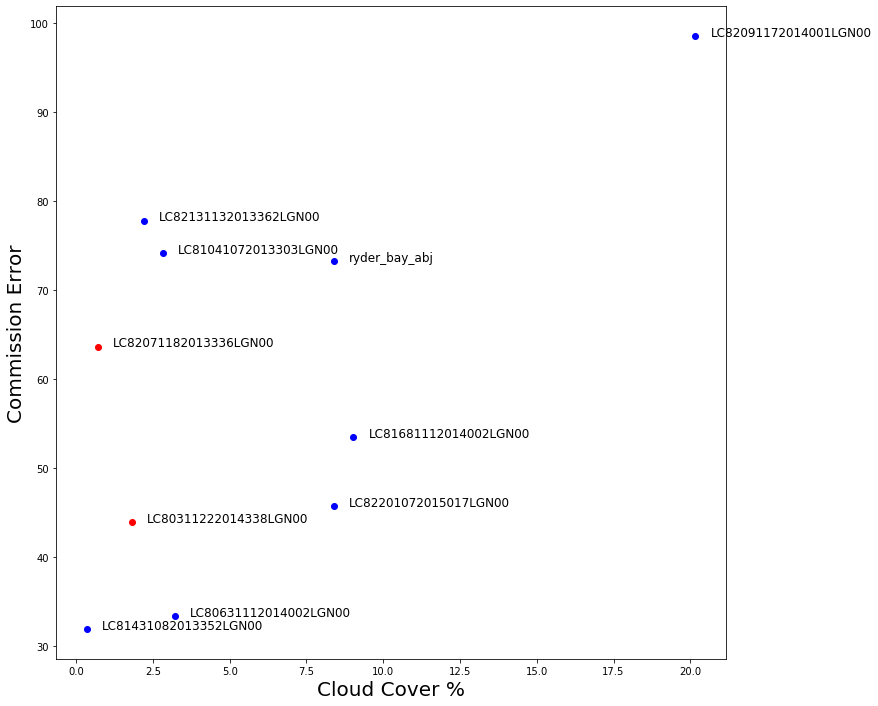

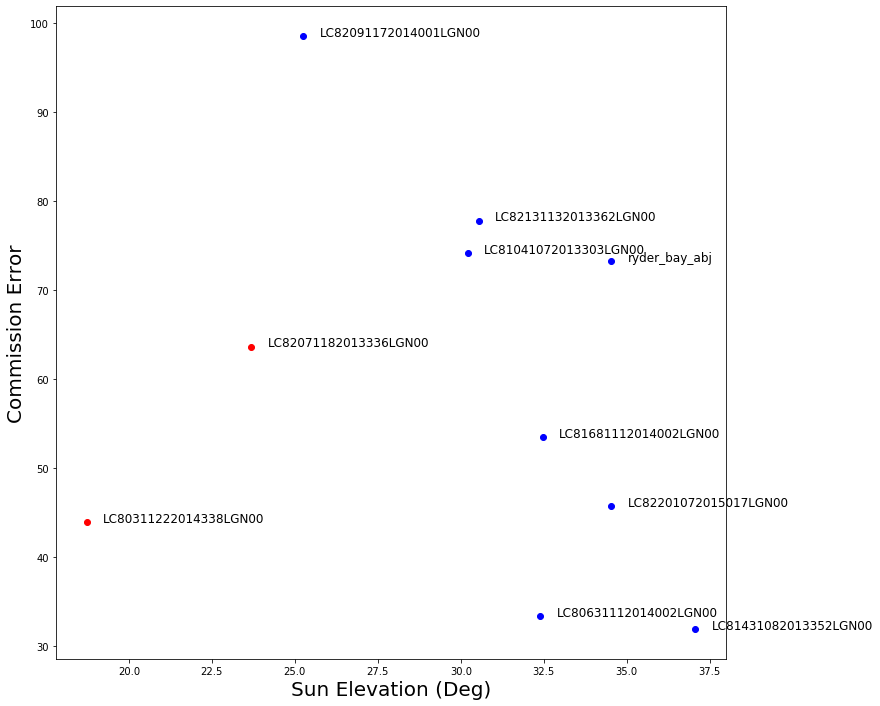

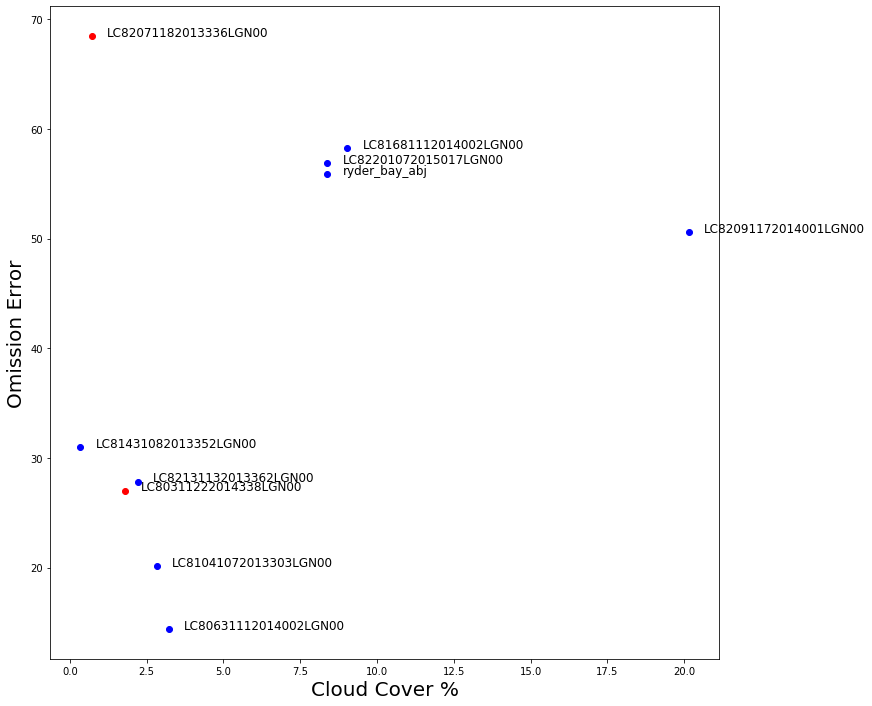

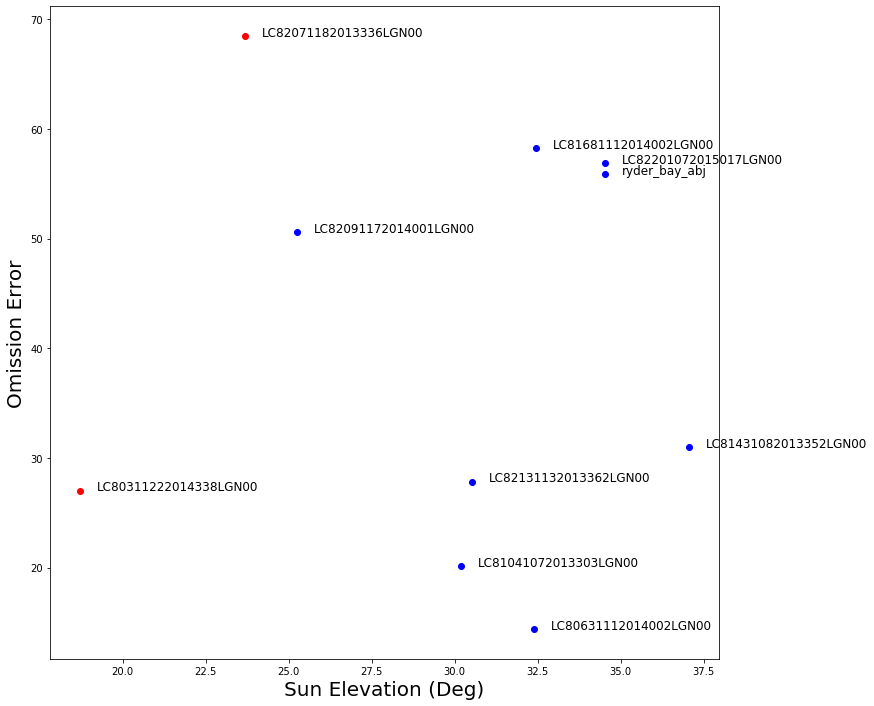

In [55]:
metrics = [("accuracy", "Overall Accuracy"), ("classification_accuracy", "Classification Accuracy"), ("rock_commission", "Commission Error"), ("rock_omission", "Omission Error")]
metadata_axes = [("CLOUD_COVER", "Cloud Cover %"), ("SUN_ELEVATION", "Sun Elevation (Deg)")]
scene_ids = list(diff_statistics.keys())
metric_trend_dir = os.path.join(base_dir, "figures", "metric_trends")
if not os.path.exists(metric_trend_dir):
    os.mkdir(metric_trend_dir)

for i in metrics:
    metric_set = [float(diff_statistics[k][i[0]]) * 100 for k in scene_ids]
    # print(len(metric_set))
    for j in metadata_axes:
        x = [float(metadata[k][j[0]]) for k in scene_ids]
        # print(len(y))
        fig, ax = plt.subplots(figsize=(12,12))
        # ax.set_title("Model Performance", fontsize=40)
        ax.set_xlabel(j[1], fontsize=20)
        ax.set_ylabel(i[1], fontsize=20)
        for k in range(len(scene_ids)):
            if scene_ids[k] in ["LC80311222014338LGN00", "LC82071182013336LGN00"]:
                ax.plot(x[k], metric_set[k], 'ro')
            else:
                ax.plot(x[k], metric_set[k], 'bo')
            ax.annotate(scene_ids[k], (x[k] + .5, metric_set[k]), fontsize=12)
        fig.savefig(os.path.join(metric_trend_dir, "{}_vs_{}.png".format(j[1], i[1])), bbox='tight', transparent=True)
        

# Load results from multiple models

In [0]:
results_dir = os.path.join(base_dir, "results")

In [0]:
epochs = [("_0", "0"), ("_5", "5"), ("_10", "10"), ("_15", "15"), ("20", "20"), ("30", "30"), ("40", "40"), ("45", "45"), ("50", "50")]
results = []
for i in epochs:
    model_path = os.path.join(results_dir, "model_allBands_epoch{}_lr_0.01".format(i[0]), "model_allBands_epoch{}_lr_0.01.JSON".format(i[0]))
    with